In [24]:
import pyro
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal
import matplotlib.pyplot as plt
import torch
import numpy as np

In [20]:
# Getting the cpt tables from bnlearn fit values
A_alias = ['adult','old','young']
S_alias = ['F','M']
E_alias = ['high','uni']
O_alias = ['emp','self']
R_alias = ['big','small']
T_alias = ['car','other','train']

A_prob = torch.tensor([0.36,0.16,0.48])
S_prob = torch.tensor([0.55, 0.45])

E_prob = torch.tensor([[[0.64, 0.36], [0.84, 0.16], [0.16, 0.84]],
                     [[0.72, 0.28], [0.89, 0.11], [0.81, 0.19]]])
O_prob = torch.tensor([[0.98, 0.02], [0.97, 0.03]])
R_prob = torch.tensor([[0.72, 0.28], [0.94, 0.06]])
T_prob = torch.tensor([[[0.71, 0.14, 0.15], [0.68, 0.16, 0.16]],
                     [[0.55, 0.08, 0.37], [0.73, 0.25, 0.02]]])

## 6 Switching to Pyro (18 points)

If you are new to tensor-based frameworks, make sure you give yourself plenty of time for this question.  It takes time to get used to debugging.  One common source of bugs is integers, *pyro* prefers you use floats (e.g., `torch.tensor(1.0)` instead of `torch.tensor(1)`).  If you hit a bug and solve it, why not share with your classmates on Piazza?

(a) Use *pyro* to reimplement the Bayesian network with parameter values you fitted in question 3.  Use default *iss* values and round parameter estimates to 2 decimal places.  Show source code.

In [16]:
def model():
    A = pyro.sample("A", dist.Categorical(probs=A_prob))
    S = pyro.sample("S", dist.Categorical(probs=S_prob))
    E = pyro.sample("E", dist.Categorical(probs=E_prob[S][A]))
    O = pyro.sample("O", dist.Categorical(probs=O_prob[E]))
    R = pyro.sample("R", dist.Categorical(probs=R_prob[E]))
    T = pyro.sample("T", dist.Categorical(probs=T_prob[R][O]))
    return{'A': A,'S': S,'E': E,'O': O,'R': R,'T': T}

In [17]:
print(model())

{'A': tensor(0), 'S': tensor(1), 'E': tensor(1), 'O': tensor(0), 'R': tensor(1), 'T': tensor(2)}


Answer the following inference questions using `pyro.condition` and (if needed) a *pyro* inference algorithm. 

(b) You observe a person with a university degree. What is your prediction of this person's means of travel?Provide either a MAP estimate or a histogram of the marginal on the variable "T". 

In [31]:
conditioned_model_uni_degree = pyro.condition(model, data={'E':torch.tensor(1)})

Text(0.5, 1.0, 'P(T | E = Uni) - Importance Sampling')

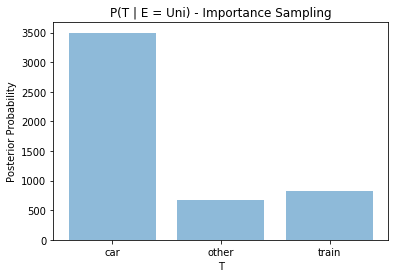

In [64]:
T_posterior = Importance(conditioned_model_uni_degree, num_samples=5000).run()
T_marginal = EmpiricalMarginal(T_posterior,"T")
T_samples = [T_marginal().item() for _ in range(5000)]
T_unique, T_counts = np.unique(T_samples, return_counts=True)

plt.bar(T_unique, T_counts, align='center', alpha=0.5)
plt.xticks(T_unique, T_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('T')
plt.title('P(T | E = Uni) - Importance Sampling')

(c) You observe a self-employed person who lives in a big city. What is your prediction of this person's age?  Provide either a MAP estimate or a histogram of the marginal on the variable "A".  

In [42]:
conditioned_model_emp_big = pyro.condition(model, data={'O': torch.tensor(1), 'R': torch.tensor(0)})

Text(0.5, 1.0, 'P(A | O=Self, R= Big) - Importance Sampling')

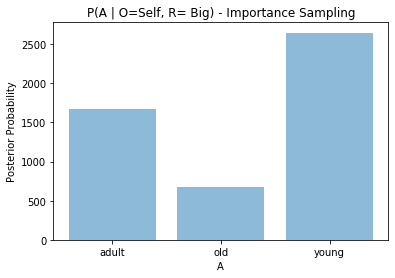

In [65]:
A_posterior = Importance(conditioned_model_emp_big, num_samples=5000).run()
A_marginal = EmpiricalMarginal(A_posterior,"A")
A_samples = [A_marginal().item() for _ in range(5000)]
A_unique, A_counts = np.unique(A_samples, return_counts=True)

plt.bar(A_unique, A_counts, align='center', alpha=0.5)
plt.xticks(A_unique, A_alias)
plt.ylabel('Posterior Probability')
plt.xlabel('A')
plt.title('P(A | O=Self, R= Big) - Importance Sampling')